In [1]:
import sklearn
import hdbscan
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import sklearn.neighbors

from scipy.io import arff
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits import mplot3d
from sklearn import metrics

In [3]:
#Datasets pour KMEAN
good_data_kmean1 = arff.loadarff(open('datasets/artificial/R15.arff','r'))
good_data_kmean2 = arff.loadarff(open('datasets/artificial/diamond9.arff','r'))
good_data_kmean3 = arff.loadarff(open('datasets/artificial/spherical_4_3.arff','r')) 

bad_data_kmean1 = arff.loadarff(open('datasets/artificial/spiral.arff','r'))
bad_data_kmean2 = arff.loadarff(open('datasets/artificial/spiralsquare.arff','r'))
bad_data_kmean3 = arff.loadarff(open('datasets/artificial/complex9.arff','r')) 

#Datasets pour Agglomerative
good_data_agglo1 = arff.loadarff(open('datasets/artificial/zelnik3.arff','r'))
good_data_agglo2 = arff.loadarff(open('datasets/artificial/dartboard1.arff','r')) 
good_data_agglo3 = arff.loadarff(open('datasets/artificial/banana.arff','r'))

bad_data_agglo1 = arff.loadarff(open('datasets/artificial/disk-4500n.arff','r'))
bad_data_agglo2 = arff.loadarff(open('datasets/artificial/golfball.arff','r')) 
bad_data_agglo3 = arff.loadarff(open('datasets/artificial/atom.arff','r'))

#Datasets pour DBSCAN
good_data_DBSCAN1 = arff.loadarff(open('datasets/artificial/zelnik2.arff','r'))
good_data_DBSCAN2 = arff.loadarff(open('datasets/artificial/zelnik4.arff','r'))
good_data_DBSCAN3 = arff.loadarff(open('datasets/artificial/cure-t2-4k.arff','r'))

bad_data_DBSCAN1 = arff.loadarff(open('datasets/artificial/square4.arff','r'))
bad_data_DBSCAN2 = arff.loadarff(open('datasets/artificial/disk-1000n.arff','r'))
bad_data_DBSCAN3 = arff.loadarff(open('datasets/artificial/rings.arff','r'))

#Datasets pour comparaison DBSAN / HDBSCAN
comp_data_H_DB1 = arff.loadarff(open('datasets/artificial/square4.arff','r'))
comp_data_H_DB2 = arff.loadarff(open('datasets/artificial/disk-1000n.arff','r'))
comp_data_H_DB3 = arff.loadarff(open('datasets/artificial/rings.arff','r'))


In [15]:
### Definition des fonctions

"""La fonction ci-dessous nous permet de récupérer les bons noms de colonnes des dataframe
car leurs noms peut changer entre les différents dataset"""

def init_df_cluster(df):
    return df[df.columns[0]], df[df.columns[1]] 

"""La fonction ci-dessous implémente la méthode des kmeans, pour une nombre maximum de 
cluster étant égal à max_clusters. La méthode retourne ensuite la valeur optimale de nombre de cluster
calculée par KMeans"""

def Kmeans(dataset, max_clusters = 20):
    
    list_kmeans, list_scores = [], []
    
    for i in range(2,max_clusters+1):
        kmeans = KMeans(n_clusters = i, random_state=0).fit(dataset)
        list_kmeans.append(kmeans)
        list_scores.append(np.mean(sklearn.metrics.silhouette_score(dataset, kmeans.labels_)))
    
    max_value = max(list_scores)
    return list_kmeans[list_scores.index(max_value)]


"""La fonction des kmeans ci-dessous propose une option permettant de s'arrêter lorsque l'amélioration
de l'inertie des clusters est inférieure à un certain pourcentage donné en paramètre. Par exemple, 
si l'inertie passe de 200 à 192, la fonction va retourner la clusterisation avec l'inertie de 192"""

def Kmeans_inertia(dataset, max_clusters = 20, pourcentage = 0.05):
    
    list_kmeans, list_scores, list_time = [], [], []
    
    for i in range(1,max_clusters):
        timer = time.time()
        kmeans = KMeans(n_clusters = i, random_state=0).fit(dataset)
        list_kmeans.append(kmeans)
        list_scores.append(kmeans.inertia_)
        list_time.append(round(time.time() - timer,4))

    best_cluster_number = len(list_scores)
    #plt.figure()
    #plt.plot(np.linspace(1,max_clusters - 1,max_clusters - 1), list_time)
    #plt.show()
    #print(list_time)

    for i in range(1, len(list_scores)):
        ecart = list_scores[i - 1] - list_scores[i] 
        if (ecart < list_scores[i - 1] * pourcentage):
            break
    return (list_kmeans[i-1])

"""La fonction ci-dessous implémente la méthode de clustering agglomératif, avec une option 'show_time'
permettant de plot le temps d'exécution en fonction du nombre de cluster choisi.
En abscisse, le nombre de cluster; en ordonnée, le temps de ms"""

def agglomerative(dataset, max_clusters = 20, show_time = False):
    
    time_list = [] 
    list_X, list_scores = [], []
    
    for i in range(2,max_clusters):
        timer = time.time()
        clusters = AgglomerativeClustering(n_clusters=i).fit(dataset)
        list_X.append(clusters)
        list_scores.append(np.mean(sklearn.metrics.silhouette_samples(dataset,clusters.labels_)))
        max_value = max(list_scores)       
        time_list.append(time.time() - timer)
               
    if(show_time):
        plt.figure()
        plt.plot(np.linspace(1,max_clusters - 2,max_clusters - 2), time_list)
        plt.show()
    return list_X[list_scores.index(max_value)]

"""Cette fonction permet de plotter les clusters calculés par la méthode agglomerative sur un dataset donné
Si le paramètre time est à true, la fonction va retourner l'évolution du temps d'exécution des algorithmes
Pour les calculs sur les 6 données mystères, il faut mettre le paramètre 'mystery' à True pour que le process s'effectue
correctement"""

def plot_agglomerative(dataset, time = False, mystery = False, Three_Dim = False): 
    dataset = process_name(dataset, mystery)
    
    solution = agglomerative(dataset, show_time = time)

    X, Y = init_df_cluster(dataset)
    plt.figure()
    #plt.scatter(*zip(*dataset), c=solution.labels_)
    
    if(Three_Dim):
        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.scatter3D(dataset.iloc[:,0], dataset.iloc[:,1], dataset.iloc[:,2], c = solution.labels_)
        plt.show()
    else:
        plt.scatter(X, Y, c = solution.labels_)
        plt.legend()
        plt.show()
    
def plot_clusters_kmeans(dataset, mystery = False):
    dataset = process_name(dataset, mystery)
    solution = Kmeans(dataset)

    X, Y = init_df_cluster(dataset)
    plt.scatter(X, Y, c = solution.labels_)
    plt.scatter(solution.cluster_centers_[:,0], solution.cluster_centers_[:,1], c='r', label = 'centers')
    plt.legend()
    
def plot_clusters_kmeans_inertia(dataset, mystery = False):
    data = process_name(dataset, mystery)
    solution = Kmeans_inertia(data)
    X, Y = init_df_cluster(data)
    plt.figure()
    plt.scatter(X, Y, c = solution.labels_)
    plt.scatter(solution.cluster_centers_[:,0], solution.cluster_centers_[:,1], c='r', label = 'centers')
    plt.legend()
    plt.show()


def plot_clusters_kmeans3D(dataset, mystery = False):
    dataset = process_name(dataset, mystery)
    clusters = Kmeans(dataset)
    X, Y = init_df_cluster(dataset)
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    ax.scatter3D(dataset.iloc[:,0], dataset.iloc[:,1], dataset.iloc[:,2], c = clusters.labels_)
    plt.legend()
    plt.show()
    
def plot_dbscan(dataset, eps_param = 0.5, min_samples_param = 10, mystery = False, Three_Dim = False):
    dataset = process_name(dataset, mystery)
    DBSCAN_result = DBSCAN(eps = eps_param, min_samples = min_samples_param).fit(dataset)
    if(Three_Dim):
        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.scatter3D(dataset.iloc[:,0], dataset.iloc[:,1], dataset.iloc[:,2], c = DBSCAN_result.labels_)
        plt.show()
    else:
        X, Y = init_df_cluster(dataset)
        plt.scatter(X,Y, c = DBSCAN_result.labels_)
    
def plot_dbscan_iteration(dataset, mystery = False, Three_Dim = False):
    
    dataset = process_name(dataset, mystery)
    X, Y = init_df_cluster(dataset)
    
    neighbor = NearestNeighbors(n_neighbors=4)
    nb_neighbors = neighbor.fit(dataset)

    distances, _ = nb_neighbors.kneighbors()
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    eps_init = np.median(distances) / 2
    eps = eps_init
    
    list_tuple, list_scores = [], []
    
    for i in range(0, 20):
        for samples in range(2,6):
            time_start = time.time()
            DBSCAN_result = DBSCAN(eps = eps, min_samples = samples).fit(dataset)
            try:
                list_scores.append(np.mean(sklearn.metrics.silhouette_samples(dataset,DBSCAN_result.labels_)))
                list_tuple.append((eps, samples))
            except:
                continue

            #print(f"Le temps d'exécution est de : {time.time() - time_start}")
            #print(DBSCAN_result.labels_)
            #print(metrics.silhouette_score(DBSCAN_result, DBSCAN_result.labels_)) <- voir bug
        eps += eps_init/2
        
    max_value = max(list_scores)
    eps, samples = list_tuple[list_scores.index(max_value)]
    
    if(Three_Dim):
        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.scatter3D(dataset.iloc[:,0], dataset.iloc[:,1], dataset.iloc[:,2], c = DBSCAN_result.labels_)
        plt.show()
    else:
        plt.figure()
        plt.scatter(X,Y, c = DBSCAN_result.labels_)
        plt.xlabel(f"eps = {eps}, le nombre de samples est de {samples}")    
        plt.legend()
        plt.show()

    
def plot_hdbscan(dataset, mystery = False, Three_Dim = False):
    dataset = process_name(dataset, mystery)
    
    X, Y = init_df_cluster(dataset)
    
    for cluster_size in range(2,10):
        clusterer = hdbscan.HDBSCAN(cluster_size)
        clusterer_labels = clusterer.fit_predict(dataset)
        
        if(Three_Dim):
            fig = plt.figure()
            ax = plt.axes(projection ='3d')
            ax.scatter3D(dataset.iloc[:,0], dataset.iloc[:,1], dataset.iloc[:,2], c = DBSCAN_result.labels_)
            plt.show()
        else:
            plt.figure()
            plt.scatter(X, Y, c = clusterer_labels)
            plt.show()


In [16]:
def process_name(dataset, mystery = False):
    df = pd.DataFrame(dataset[0])
    if(mystery):
        return df
    list_name = df.iloc[:, -1]
    list_pre, list_post, compteur = [], [], 0
    for element in list_name:
        if element not in list_pre:
            list_pre.append(element)
            list_post.append(compteur)
            compteur+=1
    for i in range(len(list_pre)):
        df.iloc[:, -1] = list_name.replace(list_pre[i], list_post[i])
    return df
    
    
    
plot_clusters_kmeans_inertia(data1)

NameError: name 'data1' is not defined

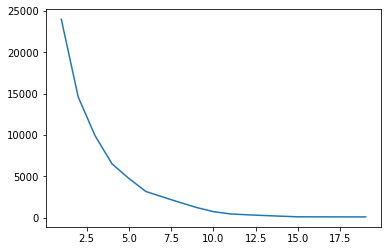

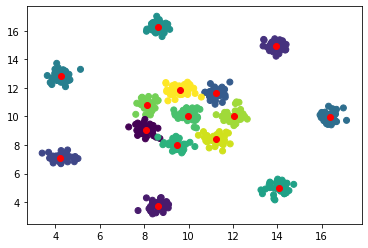

In [17]:
data = good_data_kmean1
df = pd.DataFrame(data[0])
X, Y = df['x'], df['y']

X2, Y2 = [], []
liste = []

j = 20

for i in range(1,j):
    kmeans = KMeans(n_clusters = i, random_state=0).fit(df)
    X2.append(i)
    Y2.append(kmeans.inertia_)
    liste.append(kmeans)
    
pourcentage = 0.05
best_cluster_number = len(Y2)

for i in range(1, len(Y2)):
    ecart = Y2[i - 1] - Y2[i] 
    if (ecart < Y2[i - 1] * pourcentage):
        best_cluster_number = i
        break
        

plt.figure()
plt.plot(X2, Y2)

kmeans = KMeans(n_clusters = best_cluster_number, random_state=0).fit(df)
plt.figure()
plt.scatter(X, Y, c = kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='r')

Le nombre de cluster optimal est 3
0.9187192243245286


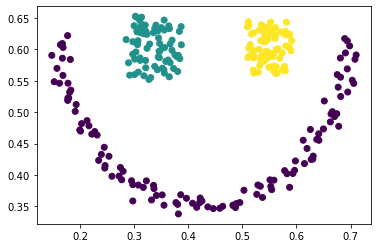

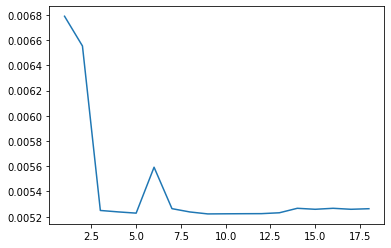

In [18]:
df = pd.DataFrame(good_data_agglo1[0])
X1, Y1 = [], []
X3, Y3 = df['x'], df['y']

list_clusters = []
time_tab = []
n = 20

for i in range(2,n):
    time_start = time.time()
    clusters = AgglomerativeClustering(n_clusters=i).fit(df)
    list_clusters.append(clusters)
    score = sklearn.metrics.silhouette_score(df,clusters.labels_)
    X1.append(i)
    Y1.append(score)
    
    time_end = time.time()
    time_exec = time_end - time_start
    time_tab.append(time_exec)

best_score = max(Y1)
index_best_score = Y1.index(best_score)

print(f"Le nombre de cluster optimal est {index_best_score + 2}")
print(best_score)

plt.figure()
plt.scatter(X3, Y3, c = list_clusters[index_best_score].labels_)
plt.show()

X = np.linspace(1,n - 2,n - 2)
plt.figure()
plt.plot(X, time_tab)

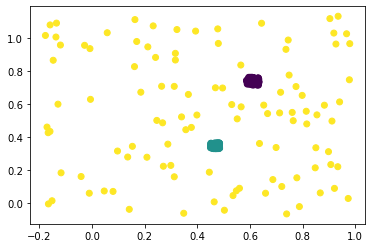

In [19]:
# DBSCAN
df = process_name(good_data_DBSCAN1)
X4, Y4 = init_df_cluster(df)

DBSCAN_result = DBSCAN(eps = 1, min_samples = 10).fit(df)
plt.scatter(X4,Y4, c = DBSCAN_result.labels_)

In [20]:
''''df = process_name(data7)
X5, Y5 = init_df_cluster(df)

#df["class"] = df["class"].replace(b'noise', b'10')

clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
clusterer_labels = clusterer.fit_predict(df)


#plt.figure()
#plt.scatter(X4, Y4, c = DBSCAN_result.labels_)'''

'\'df = process_name(data7)\nX5, Y5 = init_df_cluster(df)\n\n#df["class"] = df["class"].replace(b\'noise\', b\'10\')\n\nclusterer = hdbscan.HDBSCAN(min_cluster_size=10)\nclusterer_labels = clusterer.fit_predict(df)\n\n\n#plt.figure()\n#plt.scatter(X4, Y4, c = DBSCAN_result.labels_)'

In [21]:
#Dataset du monde réel
data_real1 = arff.loadarff(open('datasets/real-world/iris.arff','r'))
data_real2 = arff.loadarff(open('datasets/real-world/balance-scale.arff','r'))

In [25]:
colnames = ['X', 'Y', 'Z']

mystery_data1 = [pd.read_csv('mistery_dataset/a.data', sep="\t")]
mystery_data2 = [pd.read_csv('mistery_dataset/h.data', sep="\t")]
mystery_data3 = [pd.read_csv('mistery_dataset/t.data', sep="\t")]
mystery_data4 = [pd.read_csv('mistery_dataset/tr.data', sep=" ")]
mystery_data5 = [pd.read_csv('mistery_dataset/zgn.data', sep=" ")]
mystery_data6 = [pd.read_csv('mistery_dataset/zgo1.data', sep=" ")]

KMEANS


No handles with labels found to put in legend.


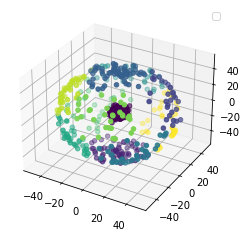

AGGLOMERATIVE


<Figure size 432x288 with 0 Axes>

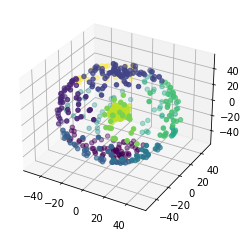

DBSCAN


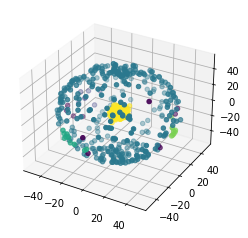

HBSCAN


ValueError: 'c' argument has 303 elements, which is inconsistent with 'x' and 'y' with size 799.

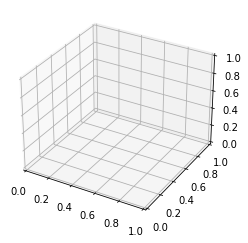

In [26]:
# Analyse des méthodes de clustering sur les datasets mystères

#Mistery1

print("KMEANS")
plot_clusters_kmeans3D(mystery_data1, mystery = True)
print("AGGLOMERATIVE")
plot_agglomerative(mystery_data1, mystery = True, Three_Dim = True)
print("DBSCAN")
plot_dbscan_iteration(mystery_data1, mystery = True, Three_Dim = True)
print("HBSCAN")
plot_hdbscan(mystery_data1, mystery = True, Three_Dim = True)